# Analyse et modélisation d'une série temporelle

Suite à la formation sur l'analyse et la modélisation des données temporelles, fournie par Openclassrooms, voici un premier projet qui met en application le contenu du cours. Il s'agira de reprendre les différentes notions du cours et de documenter les différentes étapes de l'analyse et de la modélisation. L'objectif de l'analyse est de mieux comprendre le jeu de données qu'on aura choisi, tandis que la modélisation (probabiliste) permettra de faire des statistiques prévisionnels.




In [15]:
## Modules
import pandas
import numpy
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import os

In [2]:
## Définir le répertoire de travail :
os.chdir(r"C:\Users\will\Documents\GitHub\MES_PROJETS\ANALYSE_AVION")

In [5]:
###########################################################################################################################
## DONNEES GLOBALES                                                                                                      ##
###########################################################################################################################

passagers = pandas.read_csv(".\\DONNEES\\AirPassengers.csv")

On a donc deux colonnes : la première contient les dates d'enregistrement (t) et la seconde le nombre d'enregistrement pour une date (Airpass). On peut voir que t est bien passé comme une donnée temporelle de type datetime. On commence par visualiser le jeu de données :

## Comprendre les données

In [9]:
print(passagers.info())
print(passagers.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   t        144 non-null    object
 1   Airpass  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
None
            t  Airpass
0  1949-01-01      112
1  1949-02-01      118
2  1949-03-01      132
3  1949-04-01      129
4  1949-05-01      121


In [12]:
passagers["t"] = pandas.to_datetime(passagers["t"], format="%Y-%m-%d")
passagers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   t        144 non-null    datetime64[ns]
 1   Airpass  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


C:\Users\will\AppData\Local\Temp\ipykernel_8740\2182318335.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


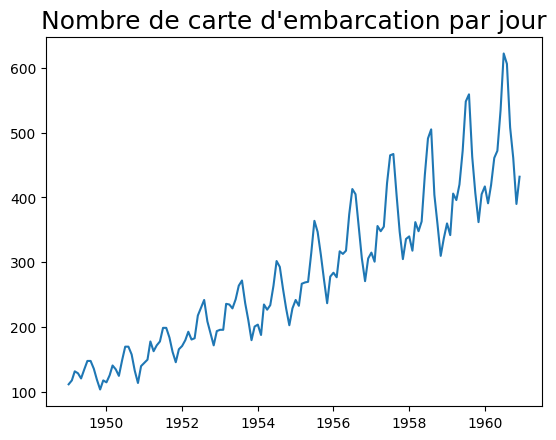

In [14]:
fig, ax = plt.subplots()
ax.plot(passagers["t"], passagers["Airpass"])
ax.set_title("Nombre de carte d'embarcation par jour", fontsize=18)
fig.show()

## Désaisonnalisation

Une donnée temporelle est appelée "série temporelle" (abrégée en TS dans la suite). La TS que nous étudions semble avoir une "variation saisonnière". Les variations saisonnières appartiennent aux 4 composantes d'une TS :
- saisonnalité,
- tendance,
- cycle,
- résidus.

Avant de nous lancer dans une modélisation prévisionnelle, nous allons étudier les 4 composantes. Ceux-ci renseignent sur la TS. L'étude, dans un premier temps, de la variation saisonnière nous informera sur la présence d'un processus répétitif infra-annuel.

La décomposition de notre série :


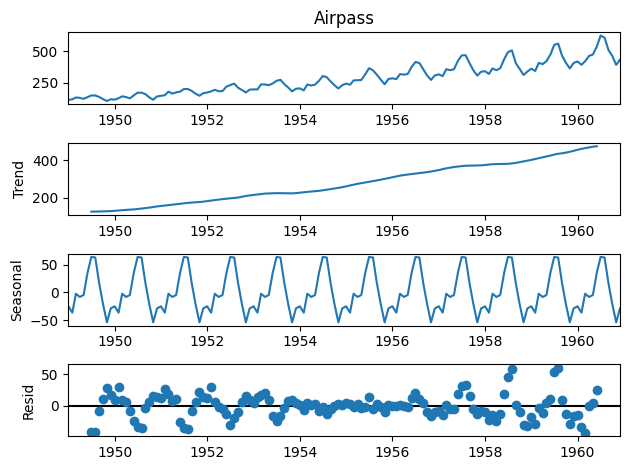

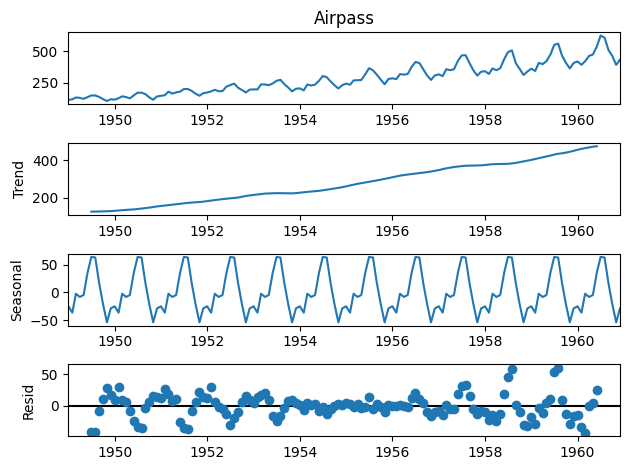

In [23]:
print("La décomposition de notre série :")

passagers.index = passagers["t"]

decomp_x = seasonal_decompose(passagers["Airpass"], model='additive') ## On tatônne pour trouver le type de modèle.
decomp_x.plot()

Il y a bien un processus infra-annuel en cours. Qui plus est, il est nécessaire de l'"absorber" de telle sorte à rendre les différents "segments" de notre TS comparables entre eux. Ci-dessus, nous avons appliqué une méthode de moyennes mobiles, qui agit comme un "filtre" permettant de décomposer la série. Pour trouver la bonne, il y a certains critères (ci-dessous) à valider.

Globalement, ces graphiques nous permettent :
- de visualiser clairement la saisonnalité,
- d'identifier une tendance à la hausse (de plus en plus de personnes vont prendre l'avion).

Il est maintenant temps d'estimer la qualité de ce filtre de moyennes mobiles. On rappelle qu'une "bonne" moyenne mobile :
- laisse la tendance invariante,
- réduit la saisonnalité à 0,
- réduit la valeur des résidus.

Nous avons bien une tendance invariante et des résidus autour de 0. 

## Modélisation

**Le choix du modèle**. Il existe de nombreux modèles pour la prévision probabiliste. Néanmoins, certains vont matcher avec les caractéristiques de notre TS et donc être plus adaptés, et avoir des propriétés utiles pour la prédiction. Mais globalement, on souhaite que notre modèle soit caractérisé par un "bruit blanc", puisque cette notion signifie l'absence de dépendance temporelle des résidus. En outre, un modèle est plus robuste lorsque la série est dite stationnaire. Une série stationnaire, c'est une série qui voit ses caractéristiques persister dans le temps.

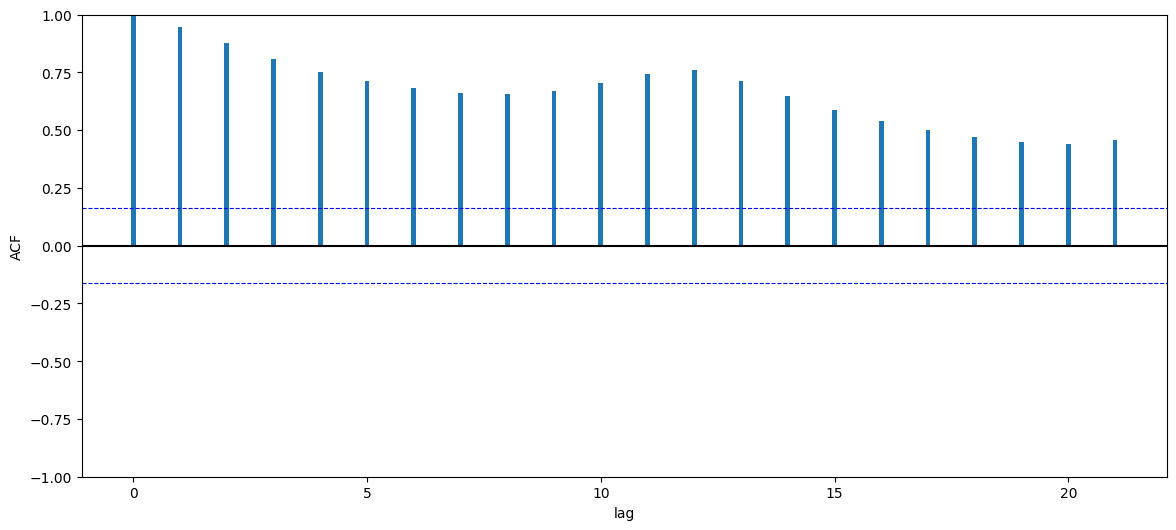

In [25]:
## Est-ce que notre TS présente des caractéristiques stationnaires ?

from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf

y_len = len(passagers['Airpass']) # variable nécessaire pour l'utilisation de plot_sortie_acf
## y_len est le décalage.

## Utilisation d'un autocorrélogramme :

plot_sortie_acf(acf(numpy.asarray(passagers['Airpass'])), y_len)
## Cette fonction plot directement l'autocorrélogramme.

Il y a visiblement une décroissance vers 0, mais pas de stationnarité.
Nous allons donc pouvoir faire une différenciation :

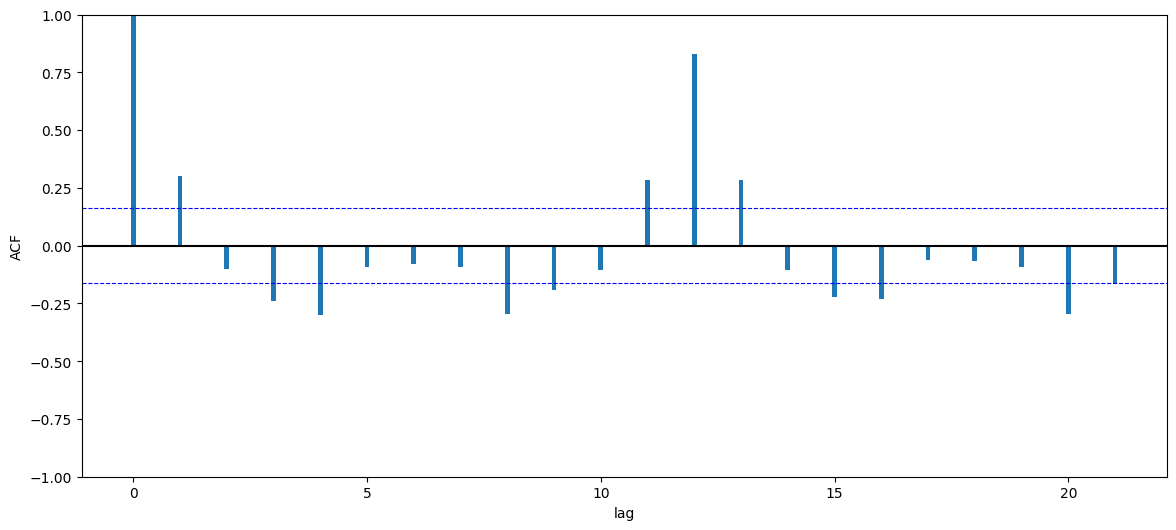

In [29]:
y_dif1 = passagers['Airpass'] - passagers['Airpass'].shift(1)

plot_sortie_acf( acf(numpy.asarray(y_dif1[1:]) ), y_len) ## On fait sauter la première valeur.

C'est pas encore ça, mais on y est presque !

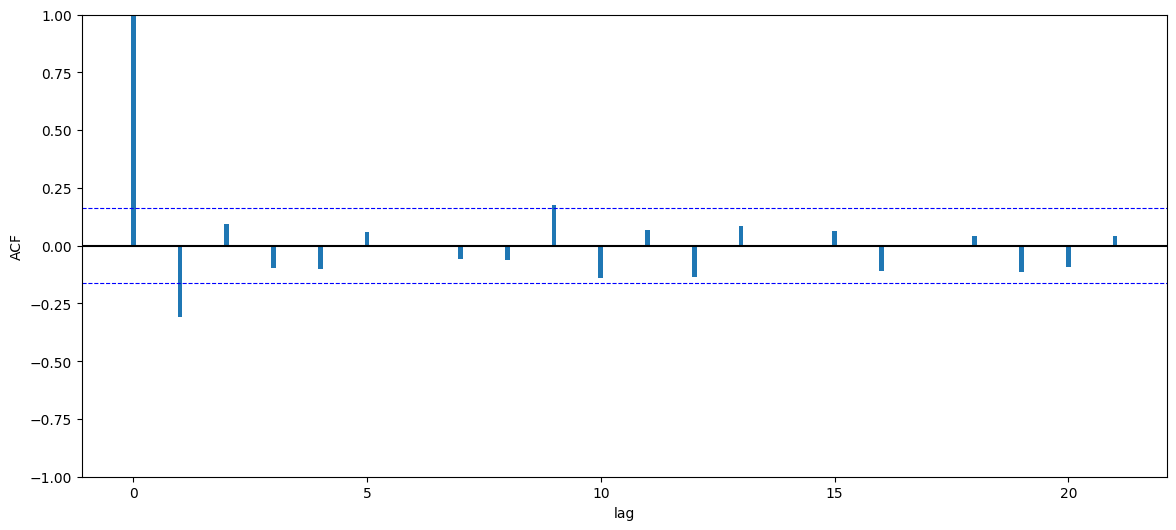

In [31]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12) ## On fait une différenciation sur 12 mois désormais

plot_sortie_acf(acf(numpy.asarray(y_dif_1_12[13:])), y_len)